<a href="https://colab.research.google.com/github/nadnik13/sparse_grid/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8FHSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import sys
from google.colab import files
from numba import cuda, vectorize

In [ ]:
uploaded = files.upload()

Saving brain.tif to brain.tif


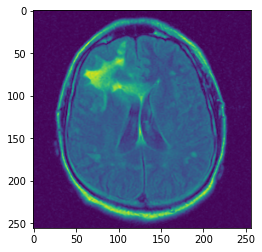

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image 
from matplotlib import image
# creating a image object (main image) 

logo = image.imread("brain.tif")

plt.imshow(logo[:,:,1]/255.)
plt.draw()
plt.show()

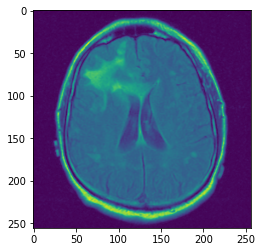

In [ ]:
img = np.array(Image.open("brain.tif").convert('L'))
plt.imshow(img)
plt.draw()
plt.show()

In [ ]:
img/255.

array([[0.01176471, 0.01176471, 0.01176471, ..., 0.00392157, 0.00392157,
        0.00784314],
       [0.01176471, 0.01176471, 0.00784314, ..., 0.00784314, 0.01176471,
        0.01176471],
       [0.00784314, 0.00392157, 0.00784314, ..., 0.00392157, 0.00784314,
        0.01176471],
       ...,
       [0.00784314, 0.00784314, 0.00784314, ..., 0.01176471, 0.00784314,
        0.00784314],
       [0.01176471, 0.00784314, 0.00784314, ..., 0.00784314, 0.01176471,
        0.00784314],
       [0.00784314, 0.00784314, 0.01568627, ..., 0.00784314, 0.01176471,
        0.00784314]])

In [ ]:
img.shape

(256, 256)

In [ ]:
# image = logo[110:115, 245:250,0:3]
image = logo[:, :,0:3]
image.shape

(256, 256, 3)

In [ ]:
n_pixls = image.shape[0] * image.shape[1]
hight = image.shape[0]
width = image.shape[1]
n_pixls, hight, width

(65536, 256, 256)

In [ ]:
image = image.reshape((-1,3))
image.shape

(65536, 3)

In [ ]:
import colorsys

image_hsv = np.array([colorsys.rgb_to_hsv(image[i][0],image[i][1], image[i][2]) for i in range(n_pixls)])


In [ ]:
image[:,:,2]

TypeError: ignored

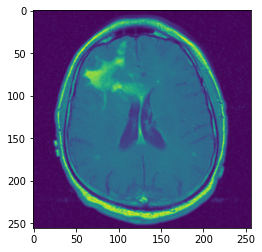

In [ ]:
image = image_hsv.reshape((hight,width,3))
plt.imshow(image[:,:,2])
plt.show()

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [ ]:
data = np.array(logo).reshape((-1,3)) / 255.0 # use 0...1 scale

In [ ]:
import cv2
from matplotlib import colors

In [ ]:
pixel_colors = logo.reshape((np.shape(logo)[0]*np.shape(logo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

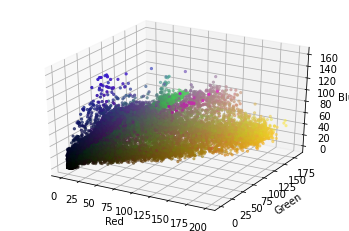

In [ ]:
r, g, b = cv2.split(logo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

In [ ]:
hsv_logo = cv2.cvtColor(logo, cv2.COLOR_RGB2HSV)

In [ ]:
hsv_logo.shape

(256, 256, 3)

In [ ]:
hsv_logo[:,:,2].shape

(256, 256)

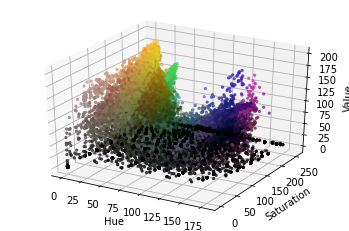

In [ ]:
h, s, v = cv2.split(hsv_logo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

NameError: ignored

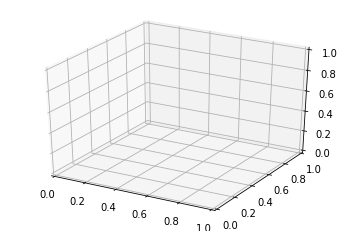

In [ ]:
h, s, v = cv2.split(logo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

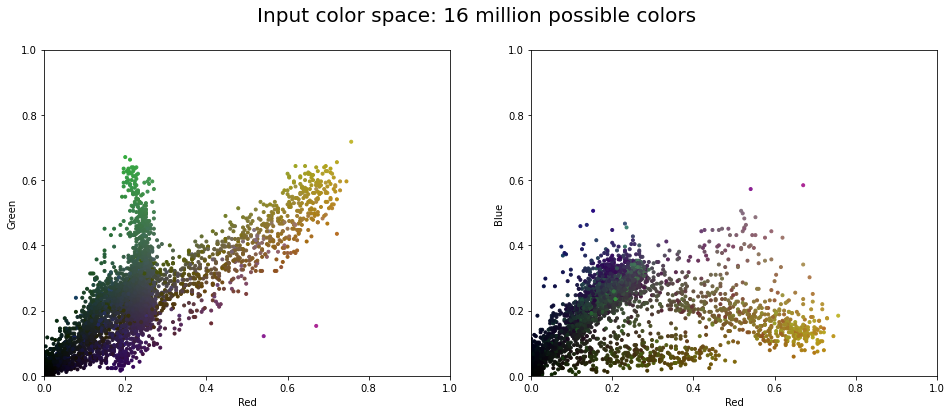

In [ ]:
plot_pixels(data, title='Input color space: 16 million possible colors')

In [ ]:
def F(color):
  return [color[2], color[2]*color[1]*math.sin(color[0]*2*math.pi), color[2]*color[1]*math.cos(color[0]*2*math.pi)]


In [ ]:
f_colors = np.zeros((n_pixls, 3))
for i in range(1,n_pixls):
  f_colors[i] = np.array(F(image_hsv[i]))

In [ ]:
f_colors[1]

array([ 5.        ,  2.93892636, -4.0450849 ])

In [ ]:
def distance(p, q):
  return math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(p, q)))

In [ ]:
def X(i):
  return [i//width, i%width]

In [ ]:
coords = np.zeros((n_pixls, 2))
for i in range(n_pixls):
  coords[i] = X(i)

In [ ]:
sigma_x = 4.0
sigma_i = 0.01
r = 5

In [ ]:
from tqdm import tqdm

In [ ]:
w = np.zeros((n_pixls, n_pixls))

In [ ]:
for ni in range(0, n_pixls):
  for nj in range(0, n_pixls):
    # print(coords[ni], coords[nj])
    dist_x = distance(coords[ni], coords[nj])
    if dist_x >= r:
      dist_x = 0
    else:
      math.exp(- dist_x*dist_x/sigma_x)
    # print(math.exp(- distance(f_colors[ni], f_colors[nj])/ sigma_i), dist_x)

    dist_f = distance(f_colors[ni], f_colors[nj])

    w[ni][nj] = math.exp(-dist_f*dist_f/ sigma_i) * dist_x

In [ ]:
A = w
A.shape
D = np.diag(A.sum(axis=1))
L = D-A
eigenvalues, eigenvectors = np.linalg.eig(L)
order = np.argsort(eigenvalues)
eigenvalues = eigenvalues[order]

In [ ]:
eigenvalues[0:10]

array([2.36907676e-42, 3.11788123e-14, 3.44163861e-04, 1.03070357e-03,
       2.30466285e-03, 3.74702700e-03, 4.86543620e-03, 7.63967959e-03,
       2.21358821e-02, 8.66507885e-02])

In [ ]:
embedding_size = 20
v_0 = eigenvectors[:, order[0]]
v_1 = eigenvectors[:, order[1]]
v_2 = eigenvectors[:, order[2]]
v = eigenvectors[:, order[1:(embedding_size+1)]]

In [ ]:
clusters = v_2 > 0
clusters

array([False,  True,  True, ..., False, False, False])

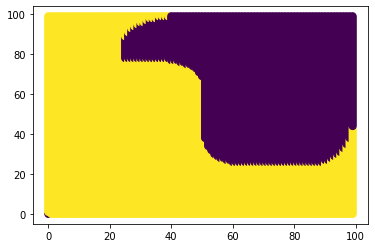

In [ ]:
points = np.array([[i,j] for i in range(0,100) for j in range(0,100)])
plt.scatter(points[:,0], points[:,1], c=clusters, s=50, cmap='viridis')

In [ ]:
from sklearn.cluster import KMeans

def getRes(n_clusters):
  kmeans = KMeans(n_clusters)
  kmeans.fit(v)
  y_kmeans = kmeans.predict(v)
  return y_kmeans.reshape((hight,width))

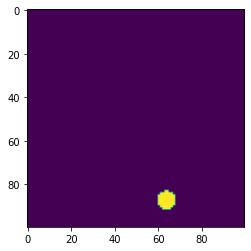

In [ ]:
plt.imshow(getRes(2))

In [ ]:
y_kmeans.reshape((hight,width))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)

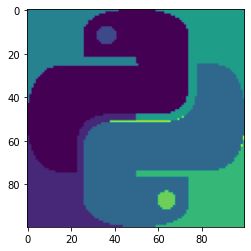

In [ ]:
plt.imshow(y_kmeans.reshape((hight,width)))
plt.draw()
plt.show()

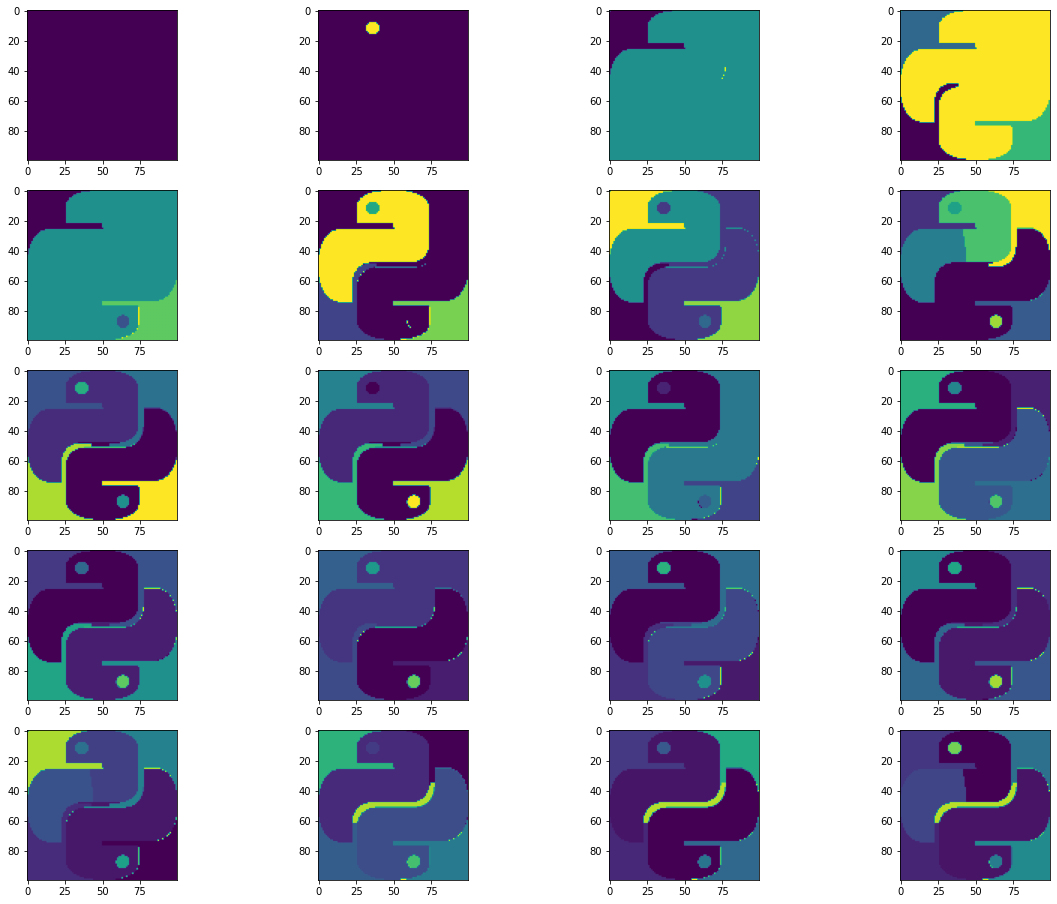

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
 
num_rows = 5
num_cols=4
fig, ax = plt.subplots(figsize=(20, 16), nrows=num_rows, ncols=num_cols)

for i in range(0,20):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].imshow(getRes(i+1))
 
plt.show()